# Benchmarking Qmachines with different RB protocols

In [1]:
!pip install tqdm

In [2]:
from RB_stabilizer_verification import machine_response_stabilizer_bench
from RB_standard_verification import machine_response_standard_bench
from RB_with_Rigetti_native_gates import machine_response_srb_native_gate
from RB_standard_verification_with_arbitrary_random_unitaries import machine_response_standard_bench_random_units
from functions import averageOfFidelity, stdOfFidelity, decay_param, decay_func
from pyquil import get_qc
from pyquil import noise

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

In [4]:
from scipy.optimize import curve_fit

In [5]:
k_m = 200 #number of sequences
n_m = 100 #number of shots
n_qubit = 2

# qmachine = get_qc( str(2) + "q-qvm" )
# qmachine = get_qc("9q-square-noisy-qvm")
qmachine = get_qc( str(n_qubit) + 'q-qvm')  # You can make any 'nq-qvm'
# qmachine = get_qc('Aspen-11',execution_timeout=60, compiler_timeout=100)

avg_std_fdlty_list = []
err_std_fdlty_list = []

avg_stab_fdlty_list = []
err_stab_fdlty_list = []

avg_rng_fdlty_list = []
err_rng_fdlty_list = []

avg_runitary_fdlty_list = []
err_runitary_fdlty_list = []

### Depolarising noise in terms of pauli channels
$$ \Lambda_{dep}(\rho) = (1-3\lambda/4)\rho + \lambda/4 X^{\dagger}\rho X + \lambda/4 Y^{\dagger}\rho Y + \lambda/4 Z^{\dagger}\rho Z $$

$$ \Lambda_{dep}(\rho) = (1-\epsilon)\rho + \frac{\epsilon}{d} I $$

So if we want to have a depolarising noise channel with $\epsilon = 0.0001$, we should define it with taking into account that $p_i = \frac{\epsilon}{4} $. So it gives

$p_i \approx 0.000025 $

In [6]:
epsilon = 0.008
p_xi = epsilon/4
qmachine.qam.gate_noise=(p_xi,p_xi,p_xi)

In [7]:
noise_model = 'depolarising_noise'
path = os.path.join( os.getcwd(), 'output_storage', noise_model, 'epsilon{}'.format(epsilon) )
try:
    os.makedirs( path )
except:
    pass

In [8]:
ordered_layers = np.arange(5,51,5).astype('int')
max_layer_num = ordered_layers[-1]

ordered_layers_arr = np.array( ordered_layers )
between_layers = np.arange(ordered_layers_arr.min(),ordered_layers_arr.max(),1).astype('int')

np.save( os.path.join(path, 'layers_indices.npy'), ordered_layers_arr )

In [9]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

In [10]:
p_xi

0.002

## RB standard version (with Clifford set)

In [11]:
for m in tqdm(ordered_layers):
    standard_response = machine_response_standard_bench(qmachine, n_qubit, m, k_m, n_m)
    avg_std_fdlty_list.append( averageOfFidelity(standard_response) )
    err_std_fdlty_list.append( stdOfFidelity(standard_response) )

np.save( os.path.join(path,'rb_standard_{}_avg_layers.npy'.format(max_layer_num)) ,np.array(avg_std_fdlty_list))    
np.save( os.path.join(path,'rb_standard_{}_err_layers.npy'.format(max_layer_num)) ,np.array(err_std_fdlty_list))    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 23.00s/it]


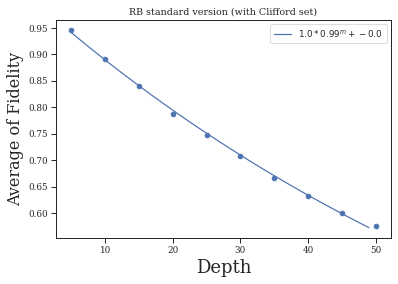

In [12]:
avg_std_fdlty_arr = np.array( avg_std_fdlty_list )
popt_std, pcov_std = curve_fit(decay_func, ordered_layers_arr, avg_std_fdlty_arr
                               , bounds=([0,0,-10], [1., 10., 0.]))

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(ordered_layers, avg_std_fdlty_list)
ax.plot(between_layers, decay_func(between_layers, *popt_std), label = r'${1}*{0}^m+{2}$'.format(*np.round(popt_std,2)))


plt.xlabel('Depth', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)
plt.title('RB standard version (with Clifford set)')

plt.legend()
fig.savefig('RB_std_clifford_gates.png')

## RB stabilizer version (with Clifford set)

In [13]:
# for m in tqdm(ordered_layers):
#     stabilizer_response = machine_response_stabilizer_bench(qmachine, n_qubit, m, k_m, n_m)
#     avg_stab_fdlty_list.append( averageOfFidelity(stabilizer_response) )
# np.save( os.path.join(path,'rb_stabilizer_{}_layers.npy'.format(max_layer_num)) ,np.array(avg_stab_fdlty_list))    

# avg_stab_fdlty_arr = np.array( avg_stab_fdlty_list )
# popt_stab, pcov_stab = curve_fit(decay_func, ordered_layers_arr, avg_stab_fdlty_arr,
#                                  bounds=([0,0,-10], [1., 10., 0.]))

# fig = plt.figure()
# ax = fig.add_subplot()

# ax.scatter(ordered_layers, avg_stab_fdlty_list)
# ax.plot(between_layers, decay_func(between_layers, *popt_stab), label = r'${1}*{0}^m+{2}$'.format(*np.round(popt_stab,2)))

# plt.xlabel('Depth', fontsize=18)
# plt.ylabel('Average of Fidelity', fontsize=16)
# plt.title('RB stabilizer version (with Clifford set)')
# plt.legend()

## RB standard version (with Riggetti native gate set)

In [14]:
for m in tqdm(ordered_layers):
    avg_rng_fdlty_list.append(averageOfFidelity(machine_response_srb_native_gate(qmachine, n_qubit, m, k_m, n_m)))
    err_rng_fdlty_list.append(stdOfFidelity(machine_response_srb_native_gate(qmachine, n_qubit, m, k_m, n_m)))

np.save( os.path.join(path,'rb_native_standard_{}_avg_layers.npy'.format(max_layer_num)) ,np.array(avg_rng_fdlty_list))
np.save( os.path.join(path,'rb_native_standard_{}_err_layers.npy'.format(max_layer_num)) ,np.array(err_rng_fdlty_list))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:41<00:00, 58.18s/it]


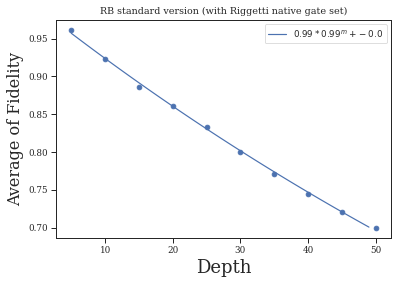

In [15]:
avg_rng_fdlty_arr = np.array( avg_rng_fdlty_list )
popt_rng, pcov_rng = curve_fit(decay_func, ordered_layers_arr, avg_rng_fdlty_arr, bounds=([0,0,-10], [1., 10., 0.]))

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(ordered_layers, avg_rng_fdlty_list)
ax.plot(between_layers, decay_func(between_layers, *popt_rng), label = r'${1}*{0}^m+{2}$'.format(*np.round(popt_rng,2)))

plt.xlabel('Depth', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)
plt.title('RB standard version (with Riggetti native gate set)')

plt.legend()

fig.savefig('RB_std_native_gates.png')

In [16]:
# plt.plot(ordered_layers, avg_rng_fdlty_list)
# plt.plot(ordered_layers, avg_std_fdlty_list)


# plt.xlabel('Layers', fontsize=18)
# plt.ylabel('Average of Fidelity', fontsize=16)

## RB standard version (with arbitary random unitary set)

In [17]:
# for m in tqdm(ordered_layers):
#     avg_runitary_fdlty_list.append(averageOfFidelity(machine_response_standard_bench_random_units(qmachine, n_qubit, m, k_m, n_m)))
#     err_runitary_fdlty_list.append(stdOfFidelity(machine_response_standard_bench_random_units(qmachine, n_qubit, m, k_m, n_m)))
    
# np.save( os.path.join(path,'rb_random_unitary_standard_{}_avg_layers.npy'.format(max_layer_num)) ,np.array(avg_runitary_fdlty_list))    
# np.save( os.path.join(path,'rb_random_unitary_standard_{}_err_layers.npy'.format(max_layer_num)) ,np.array(err_runitary_fdlty_list))    

In [18]:
# avg_runitary_fdlty_arr = np.array( avg_runitary_fdlty_list )
# popt_runitary, pcov_runitary = curve_fit(decay_func, ordered_layers_arr, avg_runitary_fdlty_arr, bounds=([0,0,-10], [1., 10., 0.]))

In [19]:
# fig = plt.figure()
# ax = fig.add_subplot()

# ax.scatter(ordered_layers, avg_runitary_fdlty_list)
# ax.plot(between_layers, decay_func(between_layers, *popt_runitary), label = r'${1}*{0}^m+{2}$'.format(*np.round(popt_runitary,2)))

# plt.xlabel('Depth', fontsize=18)
# plt.ylabel('Average of Fidelity', fontsize=16)
# plt.title('RB standard version (with arbitary random unitary set)')

# plt.legend()

## Diamond distance

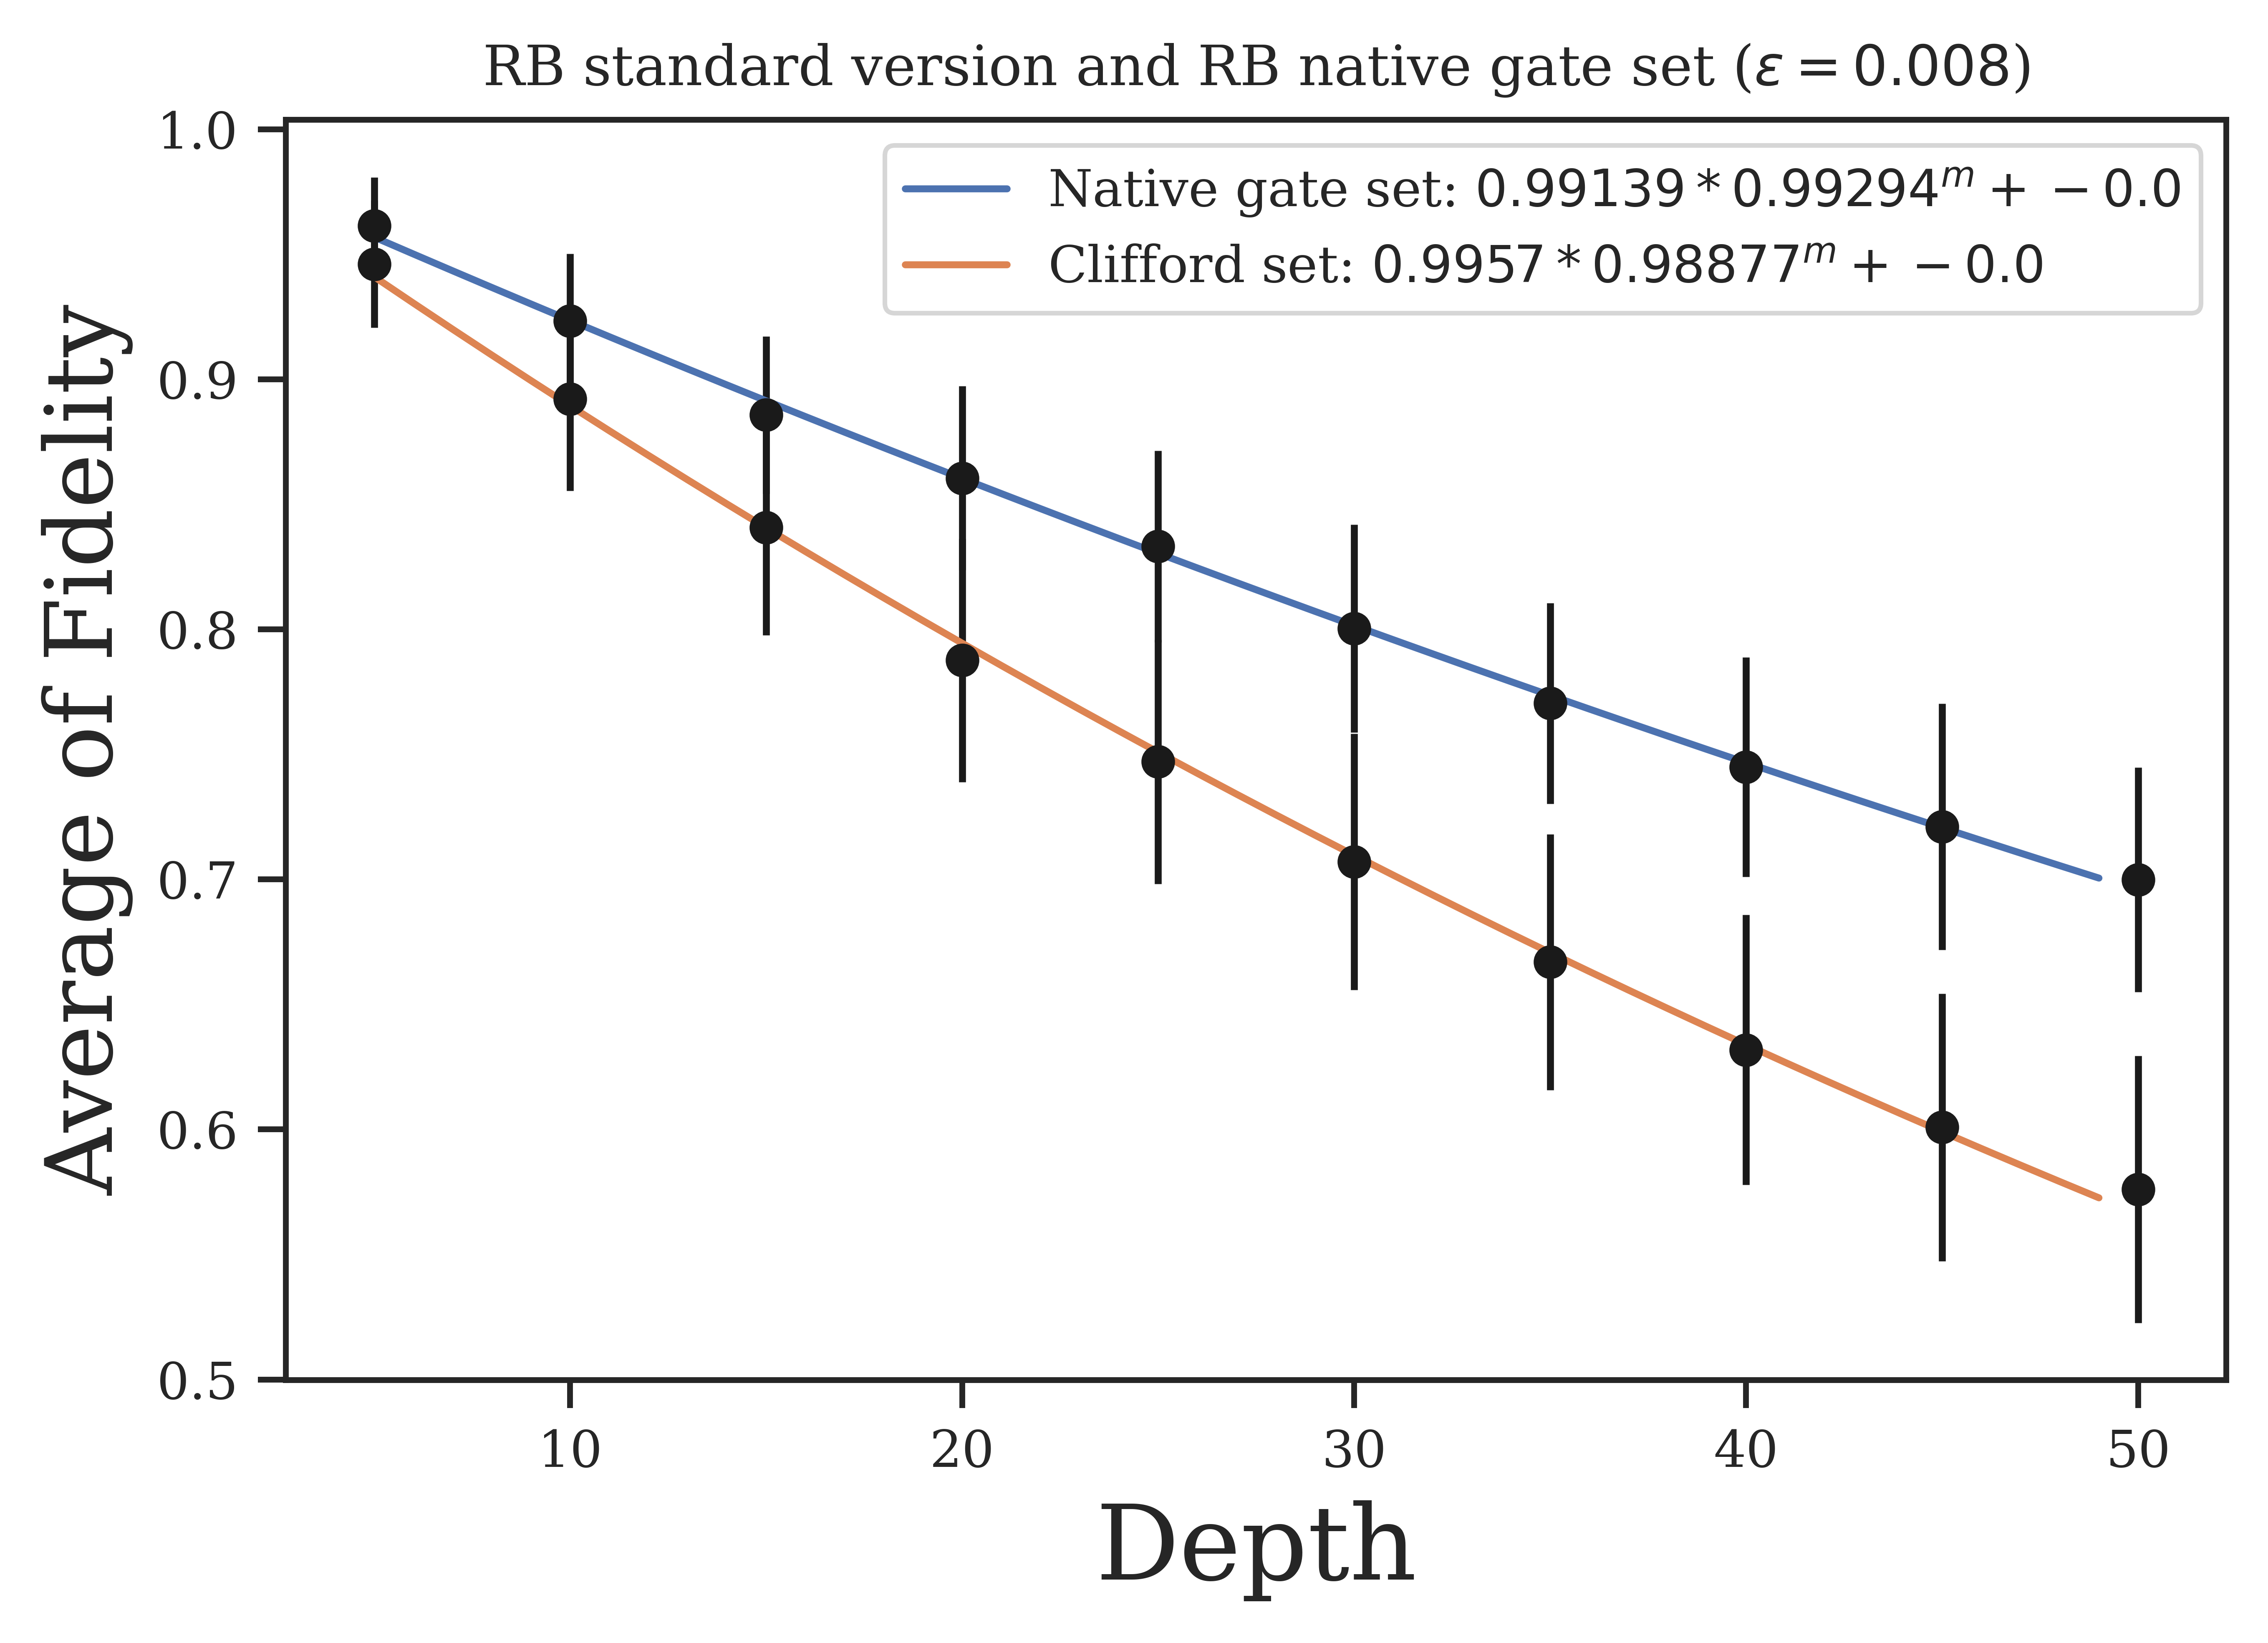

In [20]:
fig = plt.figure(dpi = 1000)
ax = fig.add_subplot()

# plt.loglog()

ax.errorbar(ordered_layers, avg_rng_fdlty_list, yerr = err_rng_fdlty_list, fmt='o',color = 'k')
ax.errorbar(ordered_layers, avg_std_fdlty_list, yerr = err_std_fdlty_list, fmt = 'o', color = 'k')

ax.plot(between_layers, decay_func(between_layers, *popt_rng),
        label = r'Native gate set: ${1}*{0}^m+{2}$'.format(*np.round(popt_rng,5)))
ax.plot(between_layers, decay_func(between_layers, *popt_std),
        label = r'Clifford set: ${1}*{0}^m+{2}$'.format(*np.round(popt_std,5)))

plt.xlabel('Depth', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)
plt.title(r'RB standard version and RB native gate set ($\epsilon = {}$)'.format(epsilon))

plt.legend()

# fig.savefig('RB_std_ntv_comparison.png')

r parameter for Native gateset

In [21]:
decay_param(popt_rng[0], n_qubit)

0.00529684089295579

r parameter for Clifford gateset

In [22]:
decay_param(popt_std[0], n_qubit)

0.008419259280941116